# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

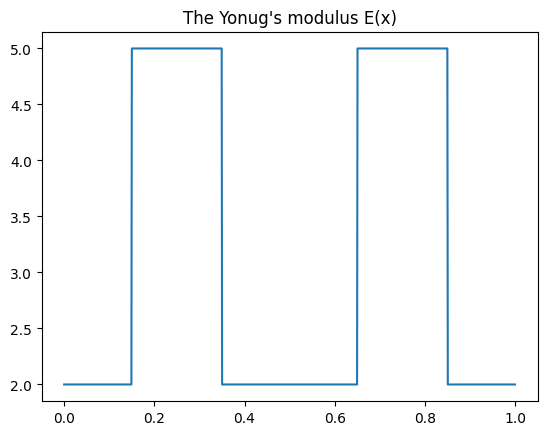

In [2]:
import numpy as np
import matplotlib.pyplot as  plt
import h5py


def E(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return np.where(np.abs(x-0.5)<0.35, np.where(np.abs(x-0.5)>0.15, phase2, phase1), phase1)
#
x = np.linspace(0., 1., 1000)
e = E(x)
#
plt.figure()
plt.plot(x,e)
plt.title("The Yonug's modulus E(x)")
plt.show()

In [3]:
# Method: Implement DeepRitz (Due to sharp boundaries are not sutiable for PINN)
# 1. Define the NN
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cpu'
dtype=torch.float32
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Activation
        self.activation = nn.Tanh()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x
#
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(1,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
              Tanh-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              Tanh-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              Tanh-6                   [-1, 40]               0
            Linear-7                   [-1, 40]           1,640
              Tanh-8                   [-1, 40]               0
            Linear-9                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------

Size of boundary points: torch.Size([2, 1])
Size of collocation points: torch.Size([10000, 1])
Size of testing points: torch.Size([1001, 1])


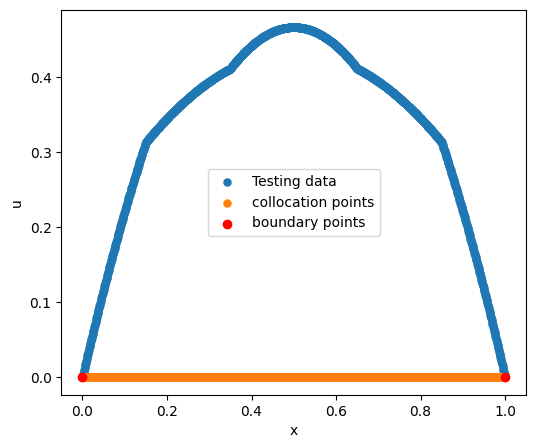

In [22]:
lb, ub = [0.], [1.]
nc = 10000  # number of collocation points
dataType = torch.float32
np.random.seed(1234)
################################# The boundary points (x=0) and (x=1)
x_lb = np.array(lb)
x_rb = np.array(ub)
#
x_bd = np.vstack([x_lb, x_rb])
x_bd = torch.tensor(x_bd, dtype=dataType)
u_bd = torch.tensor([[0.], [0.]], dtype=dataType)
print('Size of boundary points:', x_bd.shape)
################################# The collocation points (x)
x_in = np.random.uniform(lb, ub, nc).reshape(-1,1) 
x_in = torch.tensor(x_in, dtype=dataType)

print('Size of collocation points:', x_in.shape)
#print(x_in)
################################# The testing dataset (x,u)
with h5py.File('Dataset/LinearElasticity1d.h5', 'r') as data:
    #print(data.keys())
    x_test = torch.tensor(np.array(data["x_test"]), dtype=dtype)
    u_test = torch.tensor(np.array(data["u_test"]), dtype=dtype)
print('Size of testing points:', x_test.shape)
#
u_test=u_test.reshape(1001,-1)
#maxu=torch.max(u_test)
#u_test=u_test/maxu


plt.figure(figsize=(6,5))
plt.scatter(x_test, u_test, label='Testing data', linewidth=0.1)
plt.scatter(x_in, torch.zeros_like(x_in), label='collocation points', linewidth=0.1)
plt.scatter(x_bd, u_bd, color='r', label='boundary points')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()


In [23]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)

class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        ''' '''
        for d in range(self.dim):
            u = u*torch.sin(torch.pi*x[...,d:d+1])
        return u


def E_torch(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return torch.where(torch.abs(x-0.5)<0.35, torch.where(torch.abs(x-0.5)>0.15, phase2, phase1), phase1)


class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model
        self.getLoss = torch.nn.MSELoss()
        self.mollifier=Mollifier(1)
         
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        loss = 0.
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        u = self.u_model(x)
        
        # add a mollifier
        u = self.mollifier.apply(u, x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        Ex=E_torch(x)
        f = 9.81        
        ################### DeepRitz method
        energy = torch.mean(0.5 * Ex *du_dx**2 - f*u)
        return energy
    

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]
        
dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

############ Training setups
from tqdm import trange
#
epochs = 2000
lr = 1e-3
model_u = MLP([1,40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
w_pde = 5.
w_bd = 3.
############ The training process
error_list = []
for epoch in trange(epochs):
    for x_batch in dataloader:
        lossClass = LossClass(model_u)
        ############# Calculate losses
        #loss_bd = lossClass.loss_bd(x_bd, u_bd)
        loss_in = lossClass.loss_pde(x_batch)
        loss_train = loss_in
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())
    #
    scheduler.step()  # Adjust learning rate
    if (epoch+1)%200==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')


 10%|████                                    | 202/2000 [00:16<02:22, 12.63it/s]

Epoch:199, The loss is:-1.5677151679992676, lr: 0.001


 20%|████████                                | 402/2000 [00:32<02:05, 12.75it/s]

Epoch:399, The loss is:-1.508858323097229, lr: 0.001


 30%|████████████                            | 602/2000 [00:48<01:58, 11.81it/s]

Epoch:599, The loss is:-1.5959899425506592, lr: 0.0005


 40%|████████████████                        | 802/2000 [01:05<01:35, 12.58it/s]

Epoch:799, The loss is:-1.4753156900405884, lr: 0.0005


 50%|███████████████████▌                   | 1002/2000 [01:22<01:19, 12.58it/s]

Epoch:999, The loss is:-1.390398383140564, lr: 0.00025


 60%|███████████████████████▍               | 1202/2000 [01:38<01:02, 12.76it/s]

Epoch:1199, The loss is:-1.6168839931488037, lr: 0.00025


 70%|███████████████████████████▎           | 1400/2000 [01:54<00:50, 11.93it/s]

Epoch:1399, The loss is:-1.5748226642608643, lr: 0.00025


 80%|███████████████████████████████▏       | 1602/2000 [02:11<00:31, 12.49it/s]

Epoch:1599, The loss is:-1.6543927192687988, lr: 0.000125


 90%|███████████████████████████████████▏   | 1802/2000 [02:27<00:15, 12.65it/s]

Epoch:1799, The loss is:-1.7111748456954956, lr: 0.000125


100%|███████████████████████████████████████| 2000/2000 [02:43<00:00, 12.20it/s]

Epoch:1999, The loss is:-1.5648078918457031, lr: 6.25e-05


tensor(0.0134)


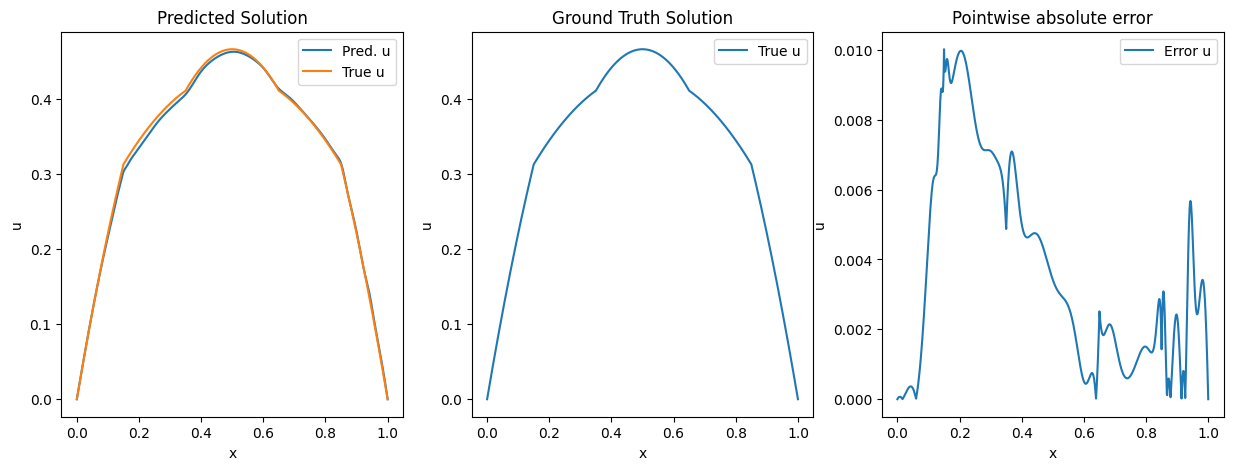

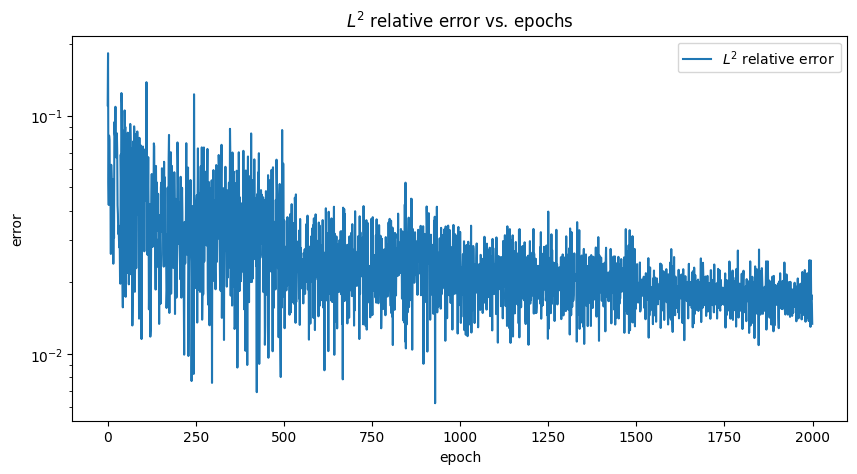

$L^2$ relative error is:0.01340397633612156


In [25]:
##### x_query = x_test
#
u_true = u_test
u_query = model_u(x_query.to(device)).detach().cpu()
u_query= Mollifier(1).apply(u_query,x_query)


error =  torch.sqrt(torch.sum((u_true-u_query)**2)/torch.sum(u_true**2))
print(error)

#
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(x_query, u_query, label='Pred. u')
ax1.plot(x_query, u_true, label='True u')
ax1.set_title('Predicted Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.legend()

ax2.plot(x_query, u_true, label='True u')
ax2.set_title('Ground Truth Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('u')
ax2.legend()

u_true=u_true.flatten()
u_query=u_query.flatten()
ax3.plot(x_query, torch.abs(u_true-u_query), label='Error u')
ax3.set_title('Pointwise absolute error')
ax3.set_xlabel('x')
ax3.set_ylabel('u')
ax3.legend()

plt.show()


fig,ax=plt.subplots(figsize=(10,5))
ax.semilogy(error_list, label='$L^2$ relative error')
ax.set_title('$L^2$ relative error vs. epochs')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()
#
plt.show()

print(f'$L^2$ relative error is:{error}')

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noise)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>
x_obs shape:  torch.Size([250, 1])
u_obs shape:  torch.Size([250, 1])
x_test shape:  torch.Size([1001, 1])
u_test shape:  torch.Size([1001, 1])
e_test shape:  torch.Size([1001, 1])


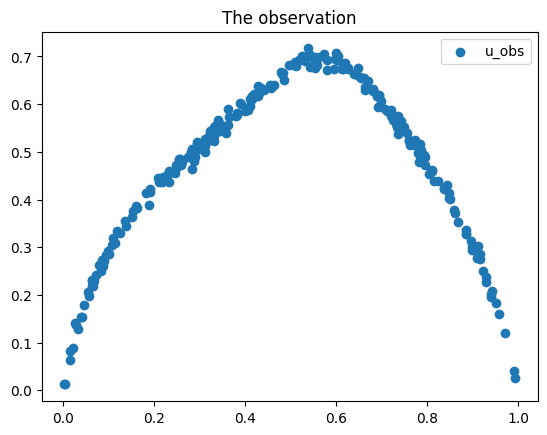

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

dtype=torch.float32
device = 'cpu'
#
with h5py.File('Dataset/LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs = torch.tensor(np.array(file['x_obs']),dtype=dtype).reshape(-1,1)
    u_obs = torch.tensor(np.array(file['u_obs']),dtype=dtype).reshape(-1,1)
    x_test = torch.tensor(np.array(file['x_test']),dtype=dtype).reshape(-1,1)
    u_test = torch.tensor(np.array(file['u_test']),dtype=dtype).reshape(-1,1)
    e_test = torch.tensor(np.array(file['e_test']),dtype=dtype).reshape(-1,1)

#
print("x_obs shape: ",x_obs.shape)
print("u_obs shape: ",u_obs.shape)
print("x_test shape: ",x_test.shape)
print("u_test shape: ",u_test.shape)
print("e_test shape: ",e_test.shape)



plt.figure()
plt.scatter(x_obs, u_obs, label='u_obs')
plt.title('The observation')
plt.legend()
plt.show()

In [11]:
# Inverse Problem

class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
        
    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)  #calculate the activation point in output layer

        return torch.nn.functional.silu(x)
####################################################
lb, ub = [0.], [1.]
#
nc = 10000
dataType = torch.float32
np.random.seed(1205)

################################# The collocation points (x,t)
x_in = np.random.uniform(lb, ub, (nc,1))
x_in = torch.tensor(x_in, dtype=dataType)
print(x_in.shape)
##################################### e_bd
x_lb=np.array(lb)
x_ub=np.array(ub)
x_bd=np.vstack([x_lb,x_ub])
x_bd = torch.tensor(x_bd, dtype=dataType)
e_bd = torch.tensor([[1.], [1.]], dtype=dataType)

torch.Size([10000, 1])


In [16]:
error_u_list, error_e_list = [],  []
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)   #u
model_e = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)   #e
optimizer = torch.optim.Adam(params=list(model_u.parameters())+list(model_e.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
# test batch size 50  epoch 1000
# To initialize, we need to run the lower section first

In [17]:
from torch.autograd import grad, Variable
import time
#
torch.manual_seed(1205)
#
class Mollifier(object):  #need to change this
    '''For capturing the zero boundary condition u(0)=u(L)=0'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        ''' '''
        for d in range(self.dim):
            u = u*torch.sin(torch.pi*x[...,d:d+1])
        return u


class LossClass(object):  

    def __init__(self, u_model, e_model):
        self.device = device
        self.u_model = u_model 
        self.e_model = e_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier(1)
    
    def loss_pde(self, x_in):   
        '''loss term related to the PDE'''
        ################# The PDE loss  (the boundary condition automatically satisfy with mollifier)
        x = Variable(x_in, requires_grad=True).to(self.device)
        #print(x.shape)
        #
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ex = self.e_model(x)
       
        s= ex*du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]
        f = 9.81   
        # The residuals
        residual = - ds_dx - f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def loss_data(self, x_obs, u_obs):
        '''loss term corresponds to the observation and prediction'''
        x = x_obs.to(self.device)
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        #
        loss = self.getLoss(u, u_obs.to(self.device))
        
        return loss


    def loss_e_bd(self, x_bd):
        '''loss term related to boundary conditions'''
        x_bd = x_bd.to(self.device)
        e = self.e_model(x_bd)
        loss = self.getLoss(e, e_bd.to(self.device))

        return loss

    def get_error_u(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
    def get_error_e(self, x_test, e_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e = self.e_model(x_test)
        
        return torch.sqrt(torch.sum((e-e_test)**2)/torch.sum(e_test**2))

########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 1)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]
        
dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

############ Training setups
from tqdm import trange
#
epochs = 3000
lr = 1e-3


############ The training process
w_pde = 5.
w_data = 200.
w_bd = 1.
t0 = time.time()
for epoch in trange(epochs):
    for x_batch in dataloader:
        lossClass = LossClass(model_u, model_e)
        ############# Calculate losses
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, u_obs)
        loss_e_bd=lossClass.loss_e_bd(x_bd)
        
        loss_train = w_pde * loss_pde + w_data * loss_data+ w_bd*loss_e_bd
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_u_list.append(error_u.item())
        error_e = lossClass.get_error_e(x_test, e_test)
        error_e_list.append(error_e.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_u_list.pop(), error_e_list.pop())
print('The consuming time is:', time.time()-t0)
     

  3%|█▎                                      | 100/3000 [00:21<09:49,  4.92it/s]

Epoch:99, The loss is:0.6789121627807617, lr: 0.001
0.04859928786754608 0.4276794493198395


  7%|██▋                                     | 200/3000 [00:42<09:50,  4.75it/s]

Epoch:199, The loss is:0.31798598170280457, lr: 0.001
0.046992190182209015 0.41007864475250244


 10%|████                                    | 301/3000 [01:03<08:54,  5.05it/s]

Epoch:299, The loss is:0.8543152809143066, lr: 0.001
0.06318473070859909 0.377640038728714


 13%|█████▎                                  | 400/3000 [01:25<09:09,  4.73it/s]

Epoch:399, The loss is:0.2607644200325012, lr: 0.001
0.042462486773729324 0.37024813890457153


 17%|██████▋                                 | 500/3000 [01:46<09:17,  4.48it/s]

Epoch:499, The loss is:0.2713531255722046, lr: 0.001
0.03970501199364662 0.3352653980255127


 20%|████████                                | 600/3000 [02:08<08:20,  4.79it/s]

Epoch:599, The loss is:0.5982550382614136, lr: 0.001
0.049100615084171295 0.34329119324684143


 23%|█████████▎                              | 700/3000 [02:30<07:51,  4.88it/s]

Epoch:699, The loss is:0.19899746775627136, lr: 0.001
0.03718727454543114 0.3104170858860016


 27%|██████████▋                             | 800/3000 [02:51<08:57,  4.09it/s]

Epoch:799, The loss is:0.14677327871322632, lr: 0.0005
0.03196809068322182 0.2674333155155182


 30%|████████████                            | 901/3000 [03:13<07:00,  5.00it/s]

Epoch:899, The loss is:0.14230622351169586, lr: 0.0005
0.03335098549723625 0.2769577205181122


 33%|█████████████                          | 1001/3000 [03:33<06:38,  5.02it/s]

Epoch:999, The loss is:0.24979442358016968, lr: 0.0005
0.03087424300611019 0.2242652177810669


 37%|██████████████▎                        | 1101/3000 [03:54<06:27,  4.90it/s]

Epoch:1099, The loss is:0.09890040755271912, lr: 0.0005
0.021259857341647148 0.18085253238677979


 40%|███████████████▌                       | 1200/3000 [04:14<06:11,  4.85it/s]

Epoch:1199, The loss is:0.0712520033121109, lr: 0.0005
0.018830081447958946 0.16175654530525208


 43%|████████████████▉                      | 1301/3000 [04:35<05:31,  5.13it/s]

Epoch:1299, The loss is:0.06443113833665848, lr: 0.0005
0.01760774664580822 0.15213583409786224


 47%|██████████████████▏                    | 1401/3000 [04:55<05:08,  5.18it/s]

Epoch:1399, The loss is:0.05746712535619736, lr: 0.0005
0.01649562269449234 0.14298582077026367


 50%|███████████████████▌                   | 1500/3000 [05:15<05:19,  4.69it/s]

Epoch:1499, The loss is:0.05962557718157768, lr: 0.00025
0.015788601711392403 0.1367909461259842


 53%|████████████████████▊                  | 1601/3000 [05:37<04:45,  4.89it/s]

Epoch:1599, The loss is:0.0498313307762146, lr: 0.00025
0.011785054579377174 0.11227680742740631


 57%|██████████████████████                 | 1700/3000 [05:57<04:56,  4.38it/s]

Epoch:1699, The loss is:0.035393550992012024, lr: 0.00025
0.010922019369900227 0.10447826981544495


 60%|███████████████████████▍               | 1800/3000 [06:18<04:14,  4.72it/s]

Epoch:1799, The loss is:0.035478658974170685, lr: 0.00025
0.011399487964808941 0.10883732885122299


 63%|████████████████████████▋              | 1900/3000 [06:39<03:47,  4.83it/s]

Epoch:1899, The loss is:0.03818092495203018, lr: 0.00025
0.009234800934791565 0.09308833628892899


 67%|██████████████████████████             | 2000/3000 [07:00<03:26,  4.85it/s]

Epoch:1999, The loss is:0.02998056635260582, lr: 0.00025
0.009117473848164082 0.09016023576259613


 70%|███████████████████████████▎           | 2100/3000 [07:21<03:09,  4.76it/s]

Epoch:2099, The loss is:0.02987782284617424, lr: 0.00025
0.009138945490121841 0.08959723263978958


 73%|████████████████████████████▌          | 2200/3000 [07:42<03:11,  4.17it/s]

Epoch:2199, The loss is:0.11383771896362305, lr: 0.00025
0.00824824534356594 0.08760672807693481


 77%|█████████████████████████████▉         | 2301/3000 [08:04<02:17,  5.07it/s]

Epoch:2299, The loss is:0.026490405201911926, lr: 0.000125
0.00803422648459673 0.0816483423113823


 80%|███████████████████████████████▏       | 2400/3000 [08:24<02:09,  4.65it/s]

Epoch:2399, The loss is:0.02551225572824478, lr: 0.000125
0.007749982178211212 0.079238161444664


 83%|████████████████████████████████▌      | 2500/3000 [08:45<01:47,  4.64it/s]

Epoch:2499, The loss is:0.025034591555595398, lr: 0.000125
0.007496548350900412 0.07718326151371002


 87%|█████████████████████████████████▊     | 2600/3000 [09:06<01:31,  4.37it/s]

Epoch:2599, The loss is:0.03862175717949867, lr: 0.000125
0.008947460912168026 0.0795605406165123


 90%|███████████████████████████████████    | 2701/3000 [09:27<00:58,  5.10it/s]

Epoch:2699, The loss is:0.025799352675676346, lr: 0.000125
0.007240192033350468 0.07469436526298523


 93%|████████████████████████████████████▍  | 2801/3000 [09:47<00:39,  4.98it/s]

Epoch:2799, The loss is:0.030138541013002396, lr: 0.000125
0.007388383615761995 0.07385712116956711


 97%|█████████████████████████████████████▋ | 2900/3000 [10:07<00:20,  4.81it/s]

Epoch:2899, The loss is:0.024362225085496902, lr: 0.000125
0.007246570196002722 0.07297810167074203


100%|███████████████████████████████████████| 3000/3000 [10:28<00:00,  4.77it/s]

Epoch:2999, The loss is:0.023781612515449524, lr: 6.25e-05
0.007240407168865204 0.07385500520467758
The consuming time is: 628.2924602031708


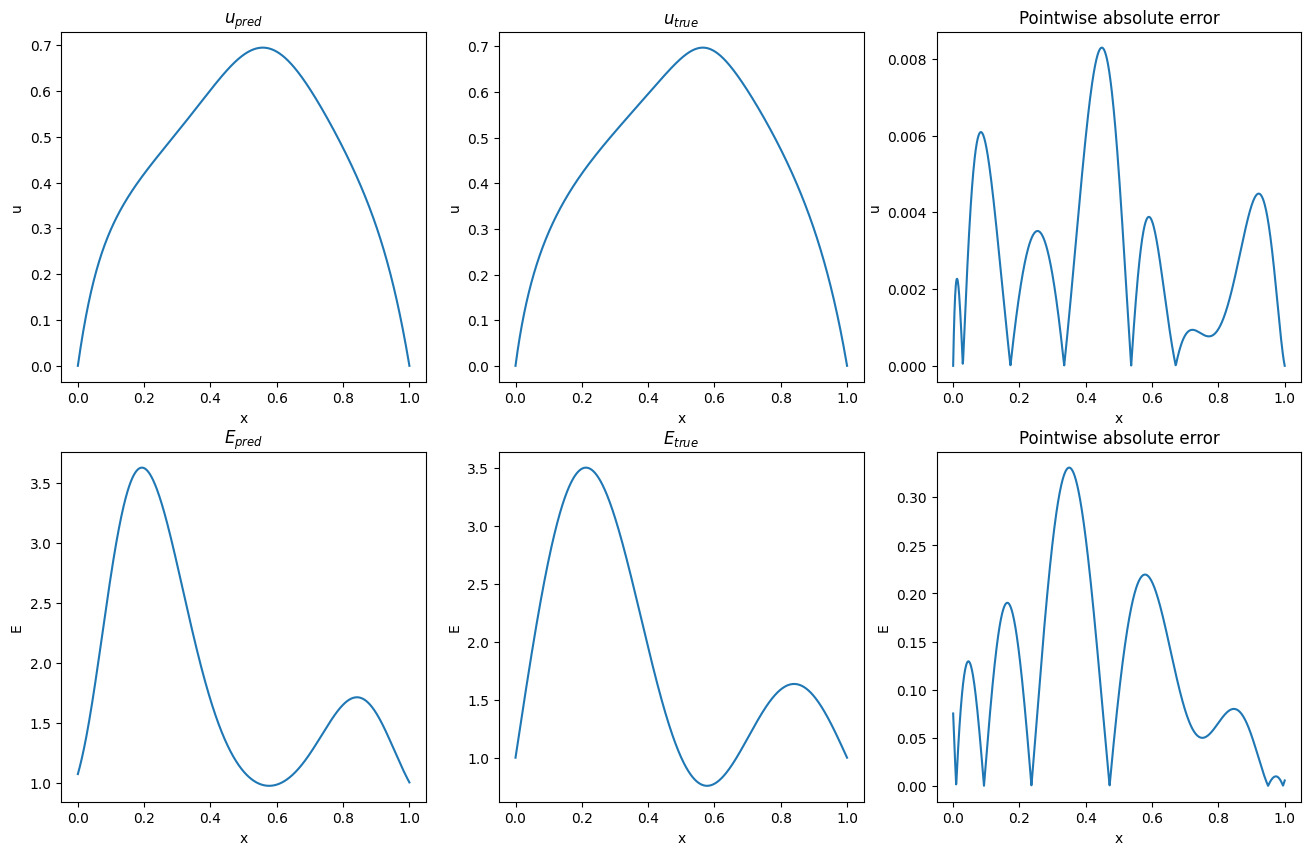

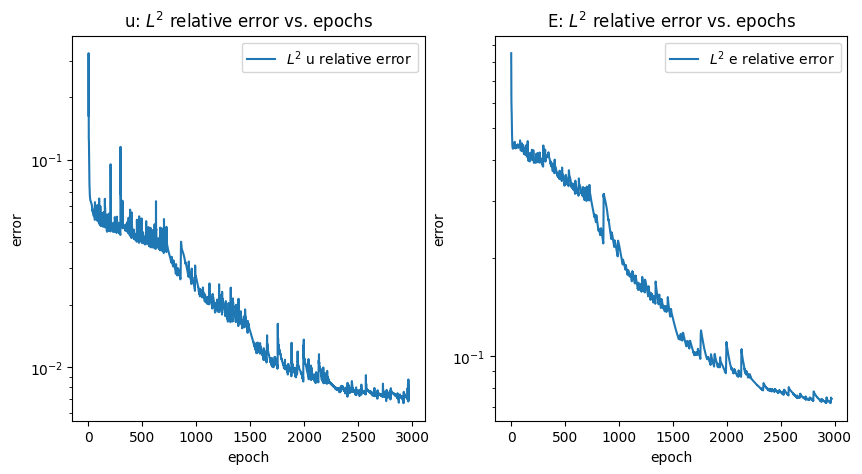

$L^2$ u relative error is:0.007240407168865204
$L^2$ e relative error is:0.07385500520467758


In [18]:
x_query = x_test
# The prediction
u_query = model_u(x_query.to(device)).detach()
u_query= Mollifier(1).apply(u_query,x_query)
u_ref = u_test
e_query = model_e(x_query.to(device)).detach()


e_ref = e_test

####### Visualize the solution
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
#
axs[0,0].plot(x_query, u_query, label='Pred. u')
axs[0,0].set_title('$u_{pred}$')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('u')
#
axs[0,1].plot(x_query, u_ref, label='True. u')
axs[0,1].set_title('$u_{true}$')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('u')
#
axs[0,2].plot(x_query, torch.abs(u_ref-u_query), label='Error. u')
axs[0,2].set_title('Pointwise absolute error')
axs[0,2].set_xlabel('x')
axs[0,2].set_ylabel('u')
#
axs[1,0].plot(x_query, e_query, label='Pred. e')
axs[1,0].set_title('$E_{pred}$')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('E')
#
axs[1,1].plot(x_query, e_ref, label='True. e')
axs[1,1].set_title('$E_{true}$')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('E')
#
axs[1,2].plot(x_query, torch.abs(e_query-e_ref), label='Error. e')
axs[1,2].set_title('Pointwise absolute error')
axs[1,2].set_xlabel('x')
axs[1,2].set_ylabel('E')
#
plt.show()

fig,ax=plt.subplots(1,2, figsize=(10,5))
ax[0].semilogy(error_u_list, label='$L^2$ u relative error')
ax[0].set_title('u: $L^2$ relative error vs. epochs')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('error')
ax[0].legend()

ax[1].semilogy(error_e_list, label='$L^2$ e relative error')
ax[1].set_title('E: $L^2$ relative error vs. epochs')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('error')
ax[1].legend()

#
plt.show()


print(f'$L^2$ u relative error is:{error_u}')
print(f'$L^2$ e relative error is:{error_e}')

